# Import a inicializace

In [15]:
#!/usr/bin/env python
import copy                                  # Kopirovani prvku
import numpy as np                           # Matematicke operace s maticemi
import random                                # Vyber nahodnych prvku
import h5py                                  # Ukladani vah site
import gym                                   # Prostredi Open AI Gym
#from gym import wrappers                    # Nahravani zaznamu
environment = "MountainCar-v0"               # Jmeno prostredi
env = gym.make(environment)                  # Konkretni hra z Open AI Gym
#env = wrappers.Monitor(env, '/home/lachubcz/tmp/cartpole-experiment-1', force=True)

%matplotlib inline
import matplotlib.pyplot as plt
from collections import deque                # Pamet
from __future__ import division              # Deleni realnych cisel (kvuli nizsi verzi Pythonu 2.6)
from tqdm import tnrange, tqdm_notebook      # Progress bar
from sources.profiling import * #profiling - @do_profile(follow=[method, ])
from sources.playing import *
from sources.visualization import *
from sources.agent import *

#Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics

#Tensorflow session
import tensorflow as tf                     # Knihovna Tensorflow
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
set_session(tf.Session(config=config))

# Parametry
observetime = 200                            # Delka pozorovani
episodes = 1                              # Pocet epizod
games = 25                                   # Pocet her
scores = []                                  # Pole pro ulozeni vysledku na analyzu
episodesList = []                            # Pole pro ulozeni cisel epizod na analyzu
bestScore = float("-inf")                    # Promenna pro ukladani nejlepsiho prubezneho vysledku
best_avg_score = float("-inf")               # Promenna pro ukladani nejlepsiho prumerneho vysledku
actionCount = env.action_space.n             # Pocet vstupu do prostredi
stateSize = env.observation_space.shape[0]   # Pocet vystupu z prostredi
agent = Agent(env)                           # Vytvoreni agenta

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_20 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 51        
Total params: 675
Trainable params: 675
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_23 (Dense)             (None, 16)      

# Algoritmus

In [16]:
rand_agent_replay(env, agent, 10000, 500, actionCount)

#agent.loadNN("./DDQN-MountainCar-v0.h5")                                     # Nacteni vah NN
#agent.updateTargetNet()                                                      # Nacteni NN do netTarget

for eps in tnrange(episodes, desc='episodes'):
    state = env.reset()                                                   # Resetovani prostredi
    total_reward = 0                                                      # Vynulovani hodnoty za kolo
    
    for t in range(observetime):
        state = np.reshape(state, (1, stateSize))                         # Formatovani
        action = agent.getActionWE(state)                                 # Ziskani akce
        nextState, reward, done, info = env.step(action)                  # Provedeni akce

        agent.remember(state, action, reward, nextState, done)            # Ulozeni stavu do pameti
        agent.trainDQN()                                                  # Trenovani pameti
        
        state = nextState                                                 # Zmena stavu
        total_reward = total_reward + reward                              # Pricteni odmeny za aktualni stav
        
        agent.epsilonActulization()                                       # Aktualizace epsilon
        if done:                                                          # Konec epizody
            #agent.updateTargetNet()                                      # Aktualizace target site
            
            if eps % 50 == 0:
                avg_score = score_estimate(env, agent, games, stateSize)  # Vypocet aktualniho skore
                scores.append(avg_score)                                  # Ulozeni aktualniho skore
                episodesList.append(eps)                                  # Ulozeni aktualniho cisla epizody
                
                print("Episode: {}/{}, epsilon: {:.2}, average score: {}".format(eps, episodes, agent.currentEpsilon, avg_score))
                
                if avg_score > best_avg_score and eps != 0:
                    best_avg_score = avg_score
                    agent_replay(env, agent,  10000, 500, stateSize)
                
                agent.saveNN("./saves/{}-{}.h5" .format(environment, eps))      # Ulozeni site
                
            if total_reward > bestScore:                                  # Bylo dosazeno nejlepsiho skore
                bestScore = total_reward                                  # Nove nejlepsi skore
                print("Episode: {}/{}, epsilon: {:.2}, new best score: {}".format(eps, episodes, agent.currentEpsilon, total_reward))
            break

agent.saveNN("./saves/{}-DONE.h5" .format(environment, eps))                    # Ulozeni site

A Jupyter Widget

Episode: 0/1, epsilon: 1.0, average score: -200.0
Episode: 0/1, epsilon: 1.0, new best score: -200.0



# Interpretace výsledků

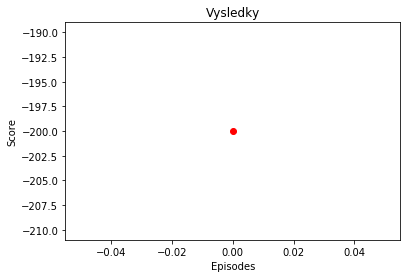

In [17]:
scattergrams_graph(scores, episodesList)

In [18]:
#learning_graph(env, agent, games, stateSize, 1000, 50, "./CartPole", "CartPole-v0-")

./Experiments-1000 - 2018-03-03-01%3A22%3A13-noki-notn-obnova


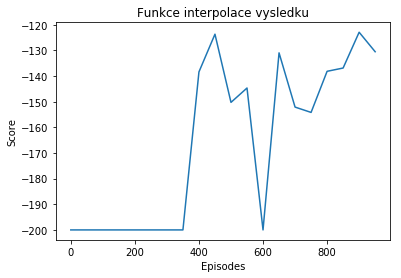

./Experiments-1000 - 2018-03-03-02%3A05%3A48-noki-notn-obnova


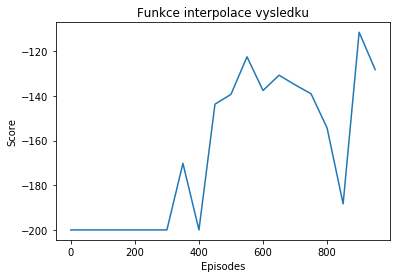

./Experiments-1000 - 2018-03-03-02%3A08%3A04-noki-notn-obnova


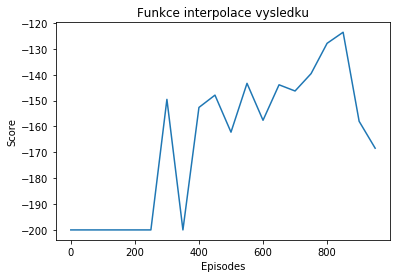

./Experiments-1000 - 2018-03-03-02%3A17%3A27-noki-notn-obnova


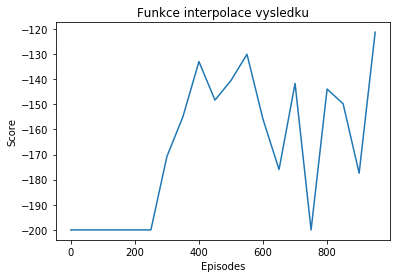

./Experiments-1000 - 2018-03-03-04%3A22%3A40-ki-notn-neobnova


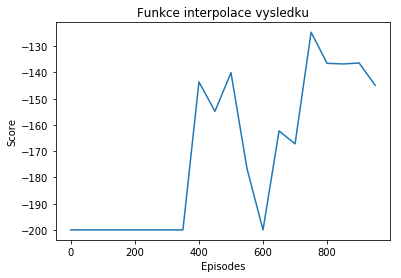

./Experiments-1000 - 2018-03-03-05%3A12%3A02-ki-notn-neobnova


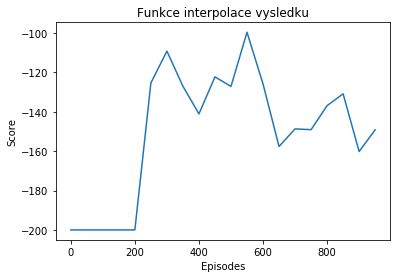

./Experiments-1000 - 2018-03-03-05%3A47%3A45-ki-notn-neobnova


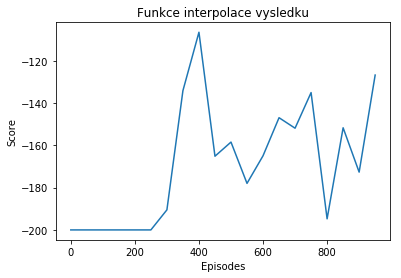

./Experiments-1000 - 2018-03-03-07%3A27%3A48-noki-tn-neobnova


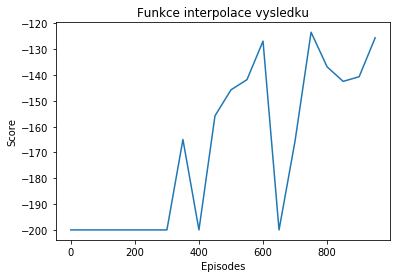

In [19]:
learning_graph(env, agent, games, stateSize, 1000, 50, "./Experiments-1000", "MountainCar-v0-")